# QuantAlpha Engine — 因子回测框架完整演示（真实数据版）

**框架结构：**
```
quant_alpha_engine/
├── data/mock_generator.py   # 模拟数据生成器（GBM + 行业共同因子）
├── ops/alpha_ops.py         # 全部算子库（时序 + 截面 + 特殊）
├── backtest/
│   ├── performance.py       # 绩效指标计算
│   └── vector_engine.py     # 矩阵式净值回测引擎
└── visualization/report.py  # Matplotlib 6子图报告
```

**工作流：**
```
真实数据加载 → 数据质量统计 → 算子组合构造因子 → VectorEngine 一行运行回测 → 自动打印指标 + 绘图
```

**数据说明：**
- 数据来源：`rawdata/repository`，包含 286 只 A 股日线数据（2025-02-26 ~ 2026-02-26）
- 过滤规则：仅保留**数据完整**（close 无 NaN）且**有完整行业信息**（申万一级行业）的股票
- 最终宇宙：约 **257 只股票**，覆盖 26 个申万一级行业

## 0. 环境准备

In [1]:
# 确认当前工作目录（需要在 quant_alpha_engine 的父目录下运行）
import os
print('当前路径:', os.getcwd())

# 如果路径不对，取消注释并修改以下行：
# os.chdir(r'D:\Stock\Frame')  # ← 修改为实际路径

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Jupyter 内联显示图表
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

当前路径: d:\2026_claude\StockFrame


## 1. 导入框架

In [2]:
from data_loader import RepositoryDataLoader, MarketData
from quant_alpha_engine import MockDataGenerator
from quant_alpha_engine.ops import AlphaOps as op
from quant_alpha_engine.backtest import VectorEngine
from quant_alpha_engine.backtest.performance import Performance

print('✅ QuantAlpha Engine 导入成功')

✅ QuantAlpha Engine 导入成功


## 2. 加载真实市场数据

使用 **RepositoryDataLoader** 从本地仓库加载真实 A 股数据，并进行以下过滤：
- ✅ 数据完整：close 价格无缺失（NaN 比例 = 0）
- ✅ 行业完整：股票在申万行业分类中有记录（sw1_name 非 Unknown）
- ✅ 交易日充足：至少 200 个有效交易日

In [ ]:
# ── 数据配置 ──────────────────────────────────────────────────
REPO_DIR   = './rawdata/repository'   # DataRepository 根目录
START_DATE = '2025-02-26'             # 回测起始日期
END_DATE   = '2026-02-26'             # 回测截止日期（None = 今天）
ADJ_TYPE   = 'hfq'                    # 'hfq'(后复权，推荐) | 'qfq'(前复权) | 'raw'(不复权)

# ── 数据过滤参数 ─────────────────────────────────────────────
MIN_TRADING_DAYS = 200     # 最少有效交易日，不足则剔除
MAX_NAN_PCT      = 0.0     # close 列最大允许 NaN 比例（0 = 严格无缺失）

# ── Step 1: 加载全部股票原始数据 ─────────────────────────────
print('► Step 1: 从仓库加载全部 OHLCV 数据...')
loader = RepositoryDataLoader(
    repo_dir     = REPO_DIR,
    limit_up_pct = 0.099,   # 涨跌停判断阈值（科创板/创业板可改为 0.199）
)

data_raw = loader.load(
    symbols          = None,              # None = 自动加载仓库中所有股票
    start_date       = START_DATE,
    end_date         = END_DATE,
    adj_type         = ADJ_TYPE,
    fill_suspended   = True,              # 停牌日用前值填充价格
    min_trading_days = MIN_TRADING_DAYS,  # 剔除数据不足的股票
)
print(f'  原始加载：{data_raw.close.shape[1]} 只股票 × {data_raw.close.shape[0]} 个交易日')

# ── Step 2: 过滤 close 数据完整的股票 ────────────────────────
print('\n► Step 2: 过滤 close 数据完整的股票...')
nan_pct = data_raw.close.isnull().mean(axis=0)  # 每只股票的 NaN 比例
valid_data = nan_pct[nan_pct <= MAX_NAN_PCT].index.tolist()
print(f'  NaN ≤ {MAX_NAN_PCT*100:.0f}%：{len(valid_data)} 只股票通过')

# ── Step 3: 过滤有完整行业信息的股票 ─────────────────────────
print('\n► Step 3: 过滤有完整申万行业信息的股票...')
has_industry = data_raw.industry[data_raw.industry != 'Unknown'].index.tolist()
print(f'  有行业信息（非 Unknown）：{len(has_industry)} 只股票通过')

# ── Step 4: 取交集，得到最终宇宙 ─────────────────────────────
valid_symbols = sorted(set(valid_data) & set(has_industry))
print(f'\n► Step 4: 最终宇宙（数据完整 ∩ 有行业信息）：{len(valid_symbols)} 只股票')

# ── Step 5: 从原始数据中截取最终宇宙的各矩阵 ─────────────────
close    = data_raw.close[valid_symbols]
open_    = data_raw.open[valid_symbols]
high     = data_raw.high[valid_symbols]
low      = data_raw.low[valid_symbols]
volume   = data_raw.volume[valid_symbols]
industry = data_raw.industry[valid_symbols]
is_susp  = data_raw.is_suspended[valid_symbols]
is_limit = data_raw.is_limit[valid_symbols]

print(f'\n✅ 数据加载完成！')
print(f'   收盘价矩阵 : {close.shape}  (交易日 × 股票)')
print(f'   日期范围   : {close.index[0].date()} ~ {close.index[-1].date()}')
print(f'   复权方式   : {ADJ_TYPE}')

In [ ]:
# ── 数据质量统计报告 ─────────────────────────────────────────
print('=' * 60)
print('  数据质量统计报告')
print('=' * 60)

T, N = close.shape
susp_pct  = is_susp.values.mean() * 100
limit_pct = is_limit.values.mean() * 100
nan_pct   = close.isnull().values.mean() * 100

print(f'\n【基本信息】')
print(f'  股票数量     : {N} 只')
print(f'  交易日数量   : {T} 个交易日')
print(f'  日期范围     : {close.index[0].date()} ~ {close.index[-1].date()}')
print(f'  复权方式     : {ADJ_TYPE}（后复权）')

print(f'\n【数据质量】')
print(f'  close NaN 比例  : {nan_pct:.4f}%   ✅' if nan_pct == 0 else f'  close NaN 比例  : {nan_pct:.4f}%')
print(f'  停牌比例        : {susp_pct:.2f}%')
print(f'  涨跌停比例      : {limit_pct:.2f}%')

# 各股票数据完整性检查
stock_nan = close.isnull().sum(axis=0)
print(f'\n【各股完整性】')
print(f'  close 全无缺失  : {(stock_nan == 0).sum()} / {N} 只')
if (stock_nan > 0).any():
    print(f'  有缺失的股票:')
    print(stock_nan[stock_nan > 0].sort_values(ascending=False).head(10))

# ── 行业分布统计 ──────────────────────────────────────────────
print(f'\n【申万一级行业分布】')
ind_count = industry.value_counts().sort_values(ascending=False)
print(f'  行业数量     : {ind_count.shape[0]} 个')
print(f'  行业分布：')
for ind_name, cnt in ind_count.items():
    bar = '█' * cnt
    print(f'  {ind_name:<10} {cnt:>3} 只  {bar}')

# ── 价格统计 ──────────────────────────────────────────────────
print(f'\n【价格统计（最后交易日收盘价）】')
last_close = close.iloc[-1].dropna()
print(f'  均值   : {last_close.mean():.2f}')
print(f'  中位数 : {last_close.median():.2f}')
print(f'  最小值 : {last_close.min():.2f}  ({last_close.idxmin()})')
print(f'  最大值 : {last_close.max():.2f}  ({last_close.idxmax()})')

print(f'\n{"=" * 60}')

# ── 行业分布柱状图 ────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5), facecolor='#1A1A2E')

# 子图1：行业股票数量
ax1 = axes[0]
ax1.set_facecolor('#16213E')
colors = plt.cm.tab20(range(len(ind_count)))
bars = ax1.barh(ind_count.index[::-1], ind_count.values[::-1], color=colors[::-1])
ax1.set_title('各申万一级行业股票数量', color='#ECF0F1', fontsize=12, pad=8)
ax1.set_xlabel('股票数量', color='#ECF0F1', fontsize=10)
ax1.tick_params(colors='#ECF0F1', labelsize=9)
for spine in ax1.spines.values():
    spine.set_color('#0F3460')
# 添加数值标签
for bar, val in zip(bars, ind_count.values[::-1]):
    ax1.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
             str(val), va='center', ha='left', color='#ECF0F1', fontsize=9)
ax1.grid(True, color='#2F3640', alpha=0.4, axis='x', linewidth=0.5)

# 子图2：停牌/涨跌停时序统计
ax2 = axes[1]
ax2.set_facecolor('#16213E')
daily_susp  = is_susp.sum(axis=1)
daily_limit = is_limit.sum(axis=1)
ax2.fill_between(daily_susp.index, daily_susp.values, alpha=0.6,
                 color='#FF4B4B', label=f'停牌股数（均值={daily_susp.mean():.1f}）')
ax2.fill_between(daily_limit.index, daily_limit.values, alpha=0.6,
                 color='#F39C12', label=f'涨跌停股数（均值={daily_limit.mean():.1f}）')
ax2.set_title('每日停牌 / 涨跌停股票数量', color='#ECF0F1', fontsize=12, pad=8)
ax2.set_xlabel('日期', color='#ECF0F1', fontsize=10)
ax2.set_ylabel('股票数', color='#ECF0F1', fontsize=10)
ax2.tick_params(colors='#ECF0F1', labelsize=8)
for spine in ax2.spines.values():
    spine.set_color('#0F3460')
ax2.legend(fontsize=9, facecolor='#1A1A2E', edgecolor='#0F3460', labelcolor='#ECF0F1')
ax2.grid(True, color='#2F3640', alpha=0.4, linewidth=0.5)

plt.tight_layout()
plt.suptitle(f'数据宇宙概览：{N} 只股票 × {T} 个交易日',
             color='#ECF0F1', fontsize=13, y=1.02)
plt.show()

In [ ]:
# ── 区间收益率统计（数据宇宙整体表现）──────────────────────
daily_ret = close.pct_change()                  # 日收益率矩阵 (T×N)
cum_ret   = (1 + daily_ret).prod(axis=0) - 1    # 区间累计收益率 (N,)
ann_vol   = daily_ret.std(axis=0) * (252 ** 0.5) # 年化波动率 (N,)

print('【区间收益率分布】（全部 {N} 只股票）'.format(N=N))
print(f'  区间涨跌幅  均值   : {cum_ret.mean()*100:+.2f}%')
print(f'  区间涨跌幅  中位数 : {cum_ret.median()*100:+.2f}%')
print(f'  区间涨跌幅  最高   : {cum_ret.max()*100:+.2f}%  ({cum_ret.idxmax()})')
print(f'  区间涨跌幅  最低   : {cum_ret.min()*100:+.2f}%  ({cum_ret.idxmin()})')
print(f'  年化波动率  均值   : {ann_vol.mean()*100:.2f}%')
print(f'  正收益股票占比     : {(cum_ret > 0).sum()} / {N}  ({(cum_ret > 0).mean()*100:.1f}%)')

# 涨幅 Top10 与 Bottom10
print(f'\n  涨幅 Top 10：')
for sym, r in cum_ret.nlargest(10).items():
    ind = industry.get(sym, '—')
    print(f'    {sym}  {r*100:+.2f}%  [{ind}]')

print(f'\n  跌幅 Bottom 10：')
for sym, r in cum_ret.nsmallest(10).items():
    ind = industry.get(sym, '—')
    print(f'    {sym}  {r*100:+.2f}%  [{ind}]')

# ── 各行业区间涨跌幅 ──────────────────────────────────────────
ind_ret = cum_ret.groupby(industry).median().sort_values(ascending=False)
print(f'\n【各申万一级行业中位数区间涨跌幅】')
for ind_name, r in ind_ret.items():
    bar = '▮' * int(abs(r) * 100)
    sign = '+' if r >= 0 else ''
    print(f'  {ind_name:<10} {sign}{r*100:.2f}%  {bar}')

# ── 行业收益率条形图 ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(13, 6), facecolor='#1A1A2E')
ax.set_facecolor('#16213E')
colors_bar = ['#2ECC71' if r > 0 else '#FF4B4B' for r in ind_ret.values]
bars = ax.barh(ind_ret.index[::-1], (ind_ret.values * 100)[::-1],
               color=colors_bar[::-1])
ax.axvline(0, color='white', linewidth=0.8, alpha=0.5)
ax.set_title(f'各申万一级行业中位数区间涨跌幅（{close.index[0].date()} ~ {close.index[-1].date()}）',
             color='#ECF0F1', fontsize=12, pad=8)
ax.set_xlabel('区间涨跌幅 (%)', color='#ECF0F1', fontsize=10)
ax.tick_params(colors='#ECF0F1', labelsize=9)
for spine in ax.spines.values():
    spine.set_color('#0F3460')
# 添加数值标签
for bar, val in zip(bars, (ind_ret.values * 100)[::-1]):
    x = bar.get_width()
    ha = 'left' if x >= 0 else 'right'
    offset = 0.3 if x >= 0 else -0.3
    ax.text(x + offset, bar.get_y() + bar.get_height()/2,
            f'{x:+.1f}%', va='center', ha=ha, color='#ECF0F1', fontsize=8)
ax.grid(True, color='#2F3640', alpha=0.4, axis='x', linewidth=0.5)
plt.tight_layout()
plt.show()

## 3. AlphaOps 算子库使用说明

所有算子均支持 `DataFrame` 向量化运算，可自由嵌套组合。

| 类别 | 算子 | 说明 |
|------|------|------|
| 时序 | `Ts_Sum / Ts_Mean / Ts_Max / Ts_Min` | 滑动窗口统计 |
| 时序 | `Ts_Delta(df, period)` | 当前值 - N天前值 |
| 时序 | `Ts_Delay(df, period)` | 数据滞后 N 天 |
| 时序 | `Ts_Std(df, window)` | 滑动窗口标准差 |
| 时序 | `Ts_Rank(df, window)` | 窗口内百分比排名 |
| 时序 | `Ts_Corr(df1, df2, window)` | 滚动相关系数 |
| 截面 | `Rank(df)` | 全市场截面百分比排名 |
| 截面 | `ZScore(df)` | 截面标准化 |
| 截面 | `Scale(df, a=1)` | 截面绝对值缩放至 a |
| 特殊 | `Decay_Linear(df, d)` | 线性加权移动平均 |
| 特殊 | `Neutralize(df, industry)` | 行业中性化（OLS残差法）|

In [5]:
# ─── 快速验证各算子 ───

# 时序算子示例
ma5   = op.Ts_Mean(close, 5)
delta = op.Ts_Delta(close, 20)
std20 = op.Ts_Std(close, 20)
corr  = op.Ts_Corr(volume, close, 10)

# 截面算子示例
rank_factor  = op.Rank(delta)
zscore_factor = op.ZScore(delta)

# 特殊算子示例
decay_factor = op.Decay_Linear(rank_factor, d=5)
neut_factor  = op.Neutralize(rank_factor, industry)

print('✅ 所有算子运行正常')
print(f'   Rank 因子范围: [{rank_factor.stack().min():.4f}, {rank_factor.stack().max():.4f}]')
print(f'   ZScore 因子均值: {zscore_factor.stack().mean():.6f}')
print(f'   Decay_Linear 因子维度: {decay_factor.shape}')
print(f'   Neutralize 后均值: {neut_factor.stack().mean():.6f}  (应接近0)')

✅ 所有算子运行正常
   Rank 因子范围: [0.0100, 1.0000]
   ZScore 因子均值: 0.000000
   Decay_Linear 因子维度: (504, 100)
   Neutralize 后均值: 0.000000  (应接近0)


In [6]:
ma5

stock,SH600000,SH600001,SH600002,SH600003,SH600004,SH600005,SH600006,SH600007,SH600008,SH600009,...,SH600090,SH600091,SH600092,SH600093,SH600094,SH600095,SH600096,SH600097,SH600098,SH600099
date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-07,12.224931,12.277492,46.011076,64.369965,30.710388,90.011061,28.989848,35.429221,34.969621,24.666659,...,49.830827,87.512384,72.313205,16.698687,98.300275,72.041090,24.964571,53.218830,32.322549,63.891807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,11.429234,13.247910,16.878607,71.126225,48.783824,153.416510,32.115628,33.649289,30.801212,28.259064,...,25.914145,68.274796,75.393207,11.447909,54.700079,53.606094,16.885052,23.174716,25.047793,133.701794
2023-12-04,11.543989,13.334584,16.885528,70.824840,49.034458,152.283899,31.853363,33.627888,30.849433,28.701007,...,26.293131,68.921278,75.340469,11.622845,54.566043,54.029815,17.016766,22.636272,24.743068,132.301361
2023-12-05,11.619144,13.434022,16.995348,70.284146,49.441483,148.486703,31.606017,33.517990,30.636636,29.024838,...,26.864167,68.720244,75.468587,11.833414,54.793182,54.686086,17.069713,22.194136,24.547042,131.289618


## 4. 构建 Alpha 因子

以下展示 3 个不同逻辑的因子，支持任意嵌套组合：

In [7]:
# ─── 因子 1：反转动量因子 ───
# 逻辑：近期跌幅越大的股票，均值回归预期更强
# 公式：Rank(-Ts_Delta(close, 5))
factor_reversal = op.Rank(-op.Ts_Delta(close, 5))
print('✅ 因子1 (反转动量): Rank(-Ts_Delta(close, 5))')

# ─── 因子 2：量价背离因子（行业中性化）───
# 逻辑：缩量上涨（量价负相关）是强势信号
# 公式：Neutralize(Rank(-Ts_Corr(volume, close, 10)), industry)
factor_volprice = op.Neutralize(
    op.Rank(-op.Ts_Corr(volume, close, window=10)),
    industry
)
print('✅ 因子2 (量价背离): Neutralize(Rank(-Ts_Corr(volume, close, 10)), industry)')

# ─── 因子 3：综合技术因子 ───
# 逻辑：线性衰减加权的动量信号，ZScore 标准化
# 公式：ZScore(Decay_Linear(Rank(Ts_Delta(close, 10)), 5))
factor_tech = op.ZScore(
    op.Decay_Linear(
        op.Rank(op.Ts_Delta(close, 10)),
        d=5
    )
)
print('✅ 因子3 (技术动量): ZScore(Decay_Linear(Rank(Ts_Delta(close, 10)), 5))')

✅ 因子1 (反转动量): Rank(-Ts_Delta(close, 5))
✅ 因子2 (量价背离): Neutralize(Rank(-Ts_Corr(volume, close, 10)), industry)
✅ 因子3 (技术动量): ZScore(Decay_Linear(Rank(Ts_Delta(close, 10)), 5))


## 5. 单因子回测

只需传入因子矩阵和行情数据，即可获得完整回测结果：

In [ ]:
# ── 回测公共配置 ──────────────────────────────────────────────────
# 修改这里即可统一影响下方所有回测
REBALANCE_FREQ = 5        # 调仓频率：5 = 每周
TOP_N          = 50       # 持仓股数（真实数据 257 只，持仓约占 20%）
WEIGHT_METHOD  = 'equal'  # 'equal' | 'factor_weighted'
COST_RATE      = 0.0015   # 单边交易成本（0.15%）

# ── 预处理参数（v2.0）────────────────────────────────────────────
# delay=d 的语义：用 T-d 日因子预测 T 日收益
# delay=1（推荐）：T-1 日因子 → T 日建仓 → 赚 T 日收益，严格无未来函数
# delay=0：T 日因子预测 T 日收益，存在 look-ahead bias，仅供研究对比
DELAY    = 1     # 1 = T-1日因子预测T日收益（标准配置，推荐）
DECAY    = 0     # 0 = 不衰减；>0 = Decay_Linear 平滑窗口
INDUSTRY = None  # None = 不做行业中性化；传入 industry Series = OLS中性化

print(f'回测配置：rebalance_freq={REBALANCE_FREQ}, top_n={TOP_N}/{N} ({TOP_N/N*100:.0f}%), '
      f'weight={WEIGHT_METHOD}, cost={COST_RATE}')
print(f'预处理：delay={DELAY}（T-{DELAY}日因子预测T日收益）, '
      f'decay={DECAY}, industry={INDUSTRY}')

In [9]:
# ─── 回测因子 1：反转动量因子 ───
print('=' * 55)
print('  回测：反转动量因子')
print('=' * 55)

engine1 = VectorEngine(
    factor         = factor_reversal,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,
    decay          = DECAY,
    industry       = INDUSTRY,
)
result1 = engine1.run()
result1.print_summary()

  回测：反转动量因子
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：504 个交易日 × 100 只股票
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=否
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！


╔═════════════════════════════════╗
║ QuantAlpha Engine — 回测绩效报告 ║
╠═════════════════════════════════╣
║  年化收益率     │       +0.50%  ║
║  年化波动率     │       +8.00%  ║
║  Sharpe Ratio   │      +0.1025  ║
║  Calmar Ratio   │      +0.0480  ║
║  最大回撤       │      -10.44%  ║
║  IC 均值        │      +0.0100  ║
║  IC 标准差      │      +0.1215  ║
║  ICIR           │      +1.3123  ║
║  IC 胜率        │      +54.22%  ║
║  IC t-stat      │      +1.8448  ║
║  日均换手率     │      +12.85%  ║
║  年化手续费     │       +4.86%  ║
║  Fitness        │      +0.0202  ║
╚═════════════════════════════════╝



  回测：量价背离因子（行业中性化）
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：504 个交易日 × 100 只股票
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=否
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！


╔═════════════════════════════════╗
║ QuantAlpha Engine — 回测绩效报告 ║
╠═════════════════════════════════╣
║  年化收益率     │       +1.68%  ║
║  年化波动率     │       +7.16%  ║
║  Sharpe Ratio   │      +0.2679  ║
║  Calmar Ratio   │      +0.1838  ║
║  最大回撤       │       -9.12%  ║
║  IC 均值        │      +0.0095  ║
║  IC 标准差      │      +0.0866  ║
║  ICIR           │      +1.7369  ║
║  IC 胜率        │      +54.86%  ║
║  IC t-stat      │      +2.4319  ║
║  日均换手率     │      +11.67%  ║
║  年化手续费     │       +4.41%  ║
║  Fitness        │      +0.1015  ║
╚═════════════════════════════════╝



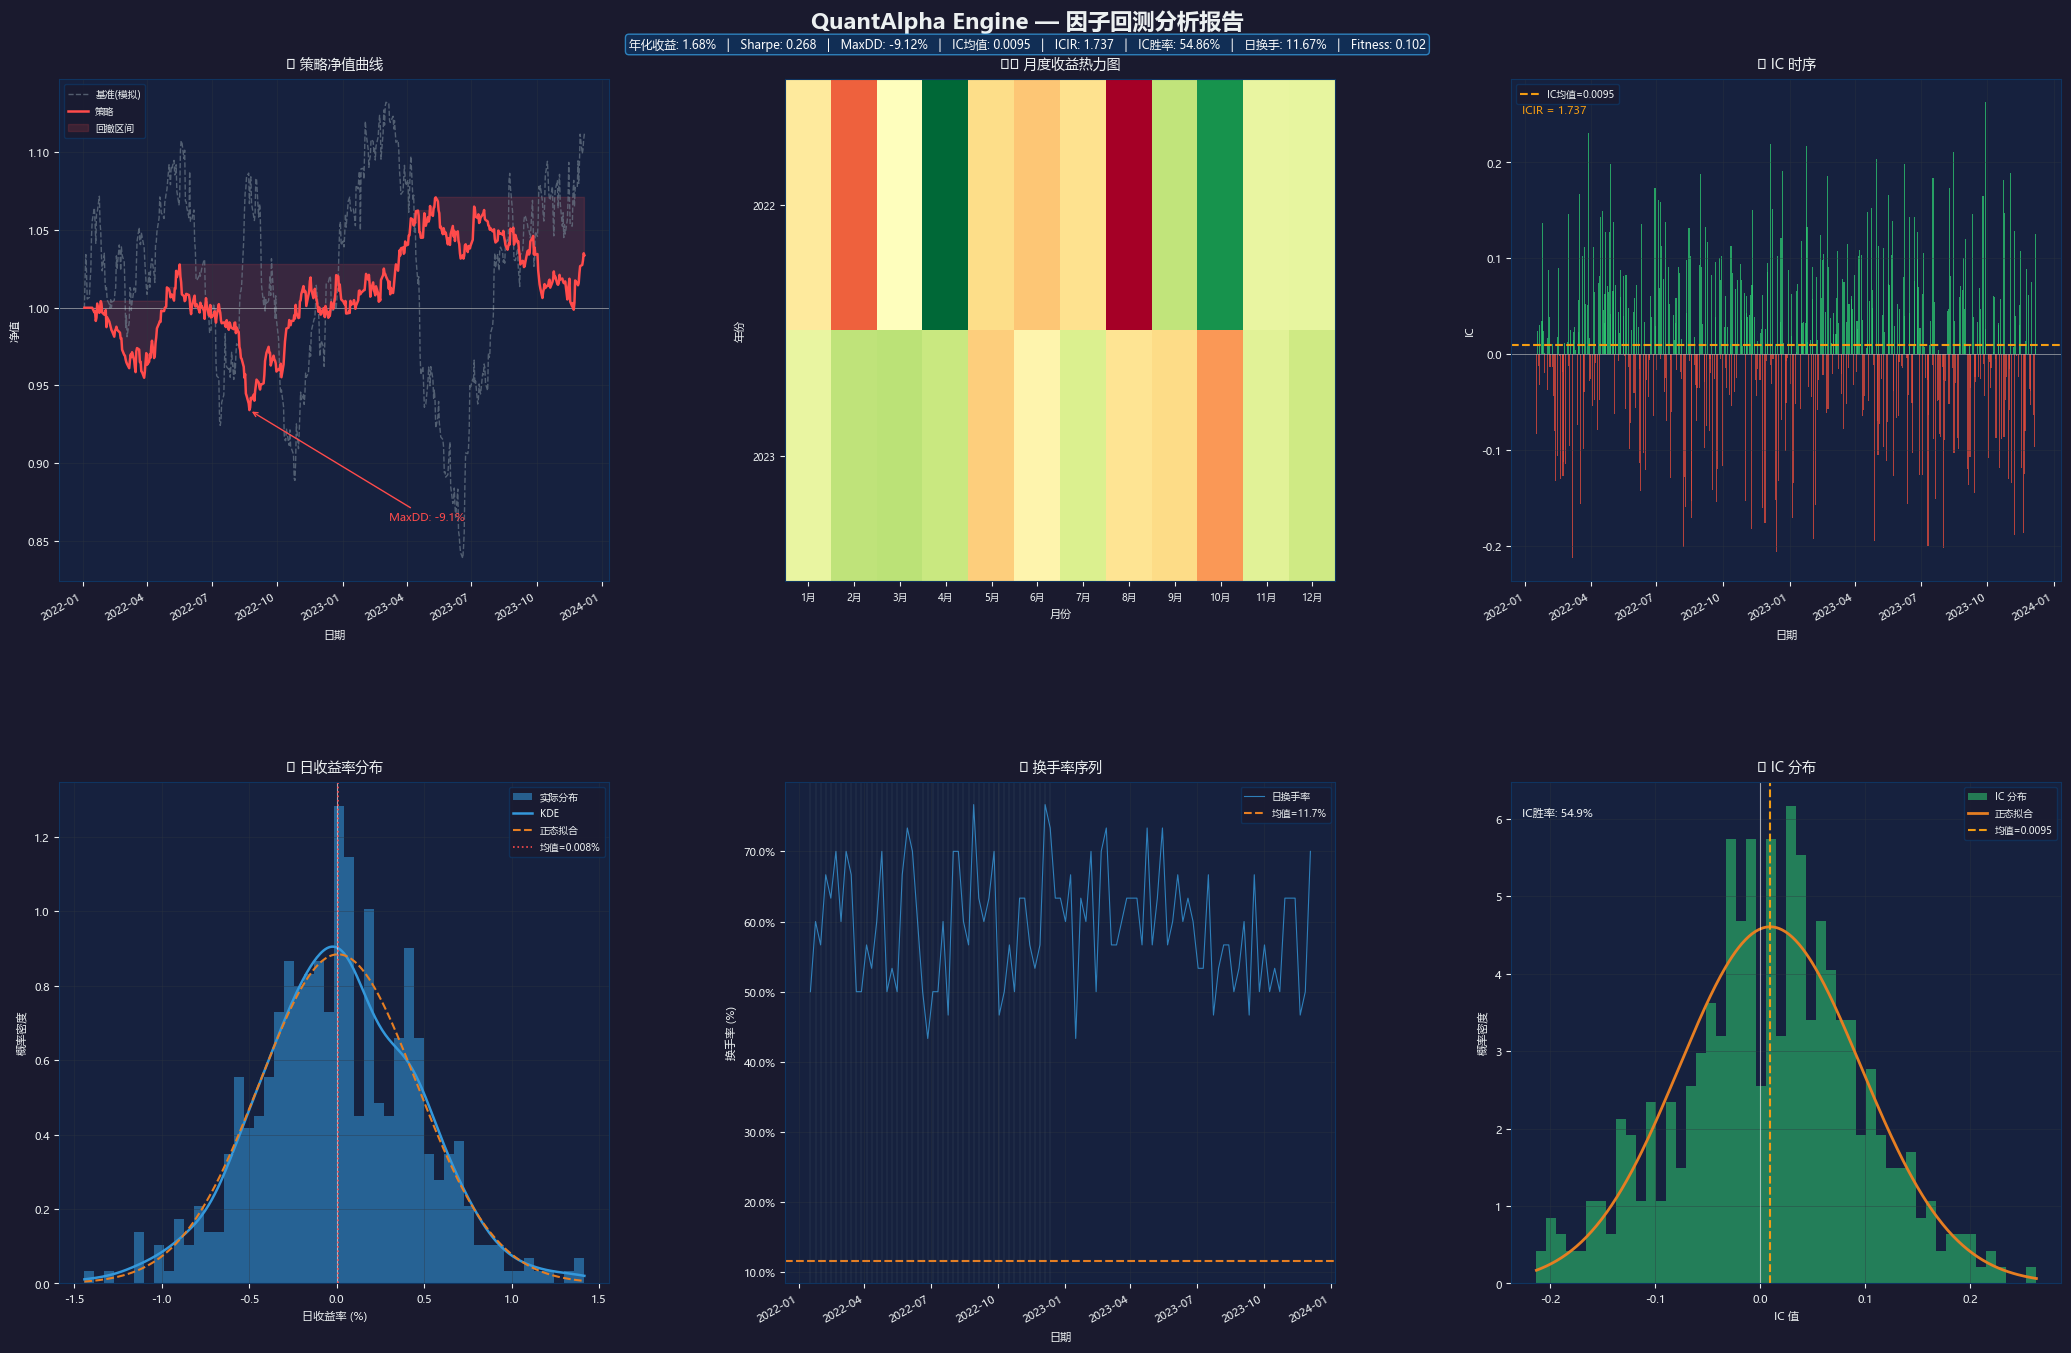

In [10]:
# ─── 回测因子 2：量价背离因子 ───
print('=' * 55)
print('  回测：量价背离因子（行业中性化）')
print('=' * 55)

engine2 = VectorEngine(
    factor         = factor_volprice,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,
    decay          = DECAY,
    industry       = INDUSTRY,
)
result2 = engine2.run()
result2.print_summary()
result2.plot()

  回测：综合技术因子
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：504 个交易日 × 100 只股票
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=否
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！


╔═════════════════════════════════╗
║ QuantAlpha Engine — 回测绩效报告 ║
╠═════════════════════════════════╣
║  年化收益率     │       -1.12%  ║
║  年化波动率     │       +7.80%  ║
║  Sharpe Ratio   │      -0.1058  ║
║  Calmar Ratio   │      -0.1130  ║
║  最大回撤       │       -9.93%  ║
║  IC 均值        │      -0.0024  ║
║  IC 标准差      │      +0.1231  ║
║  ICIR           │      -0.3143  ║
║  IC 胜率        │      +46.75%  ║
║  IC t-stat      │      -0.4391  ║
║  日均换手率     │       +8.32%  ║
║  年化手续费     │       +3.15%  ║
║  Fitness        │      -0.0389  ║
╚═════════════════════════════════╝



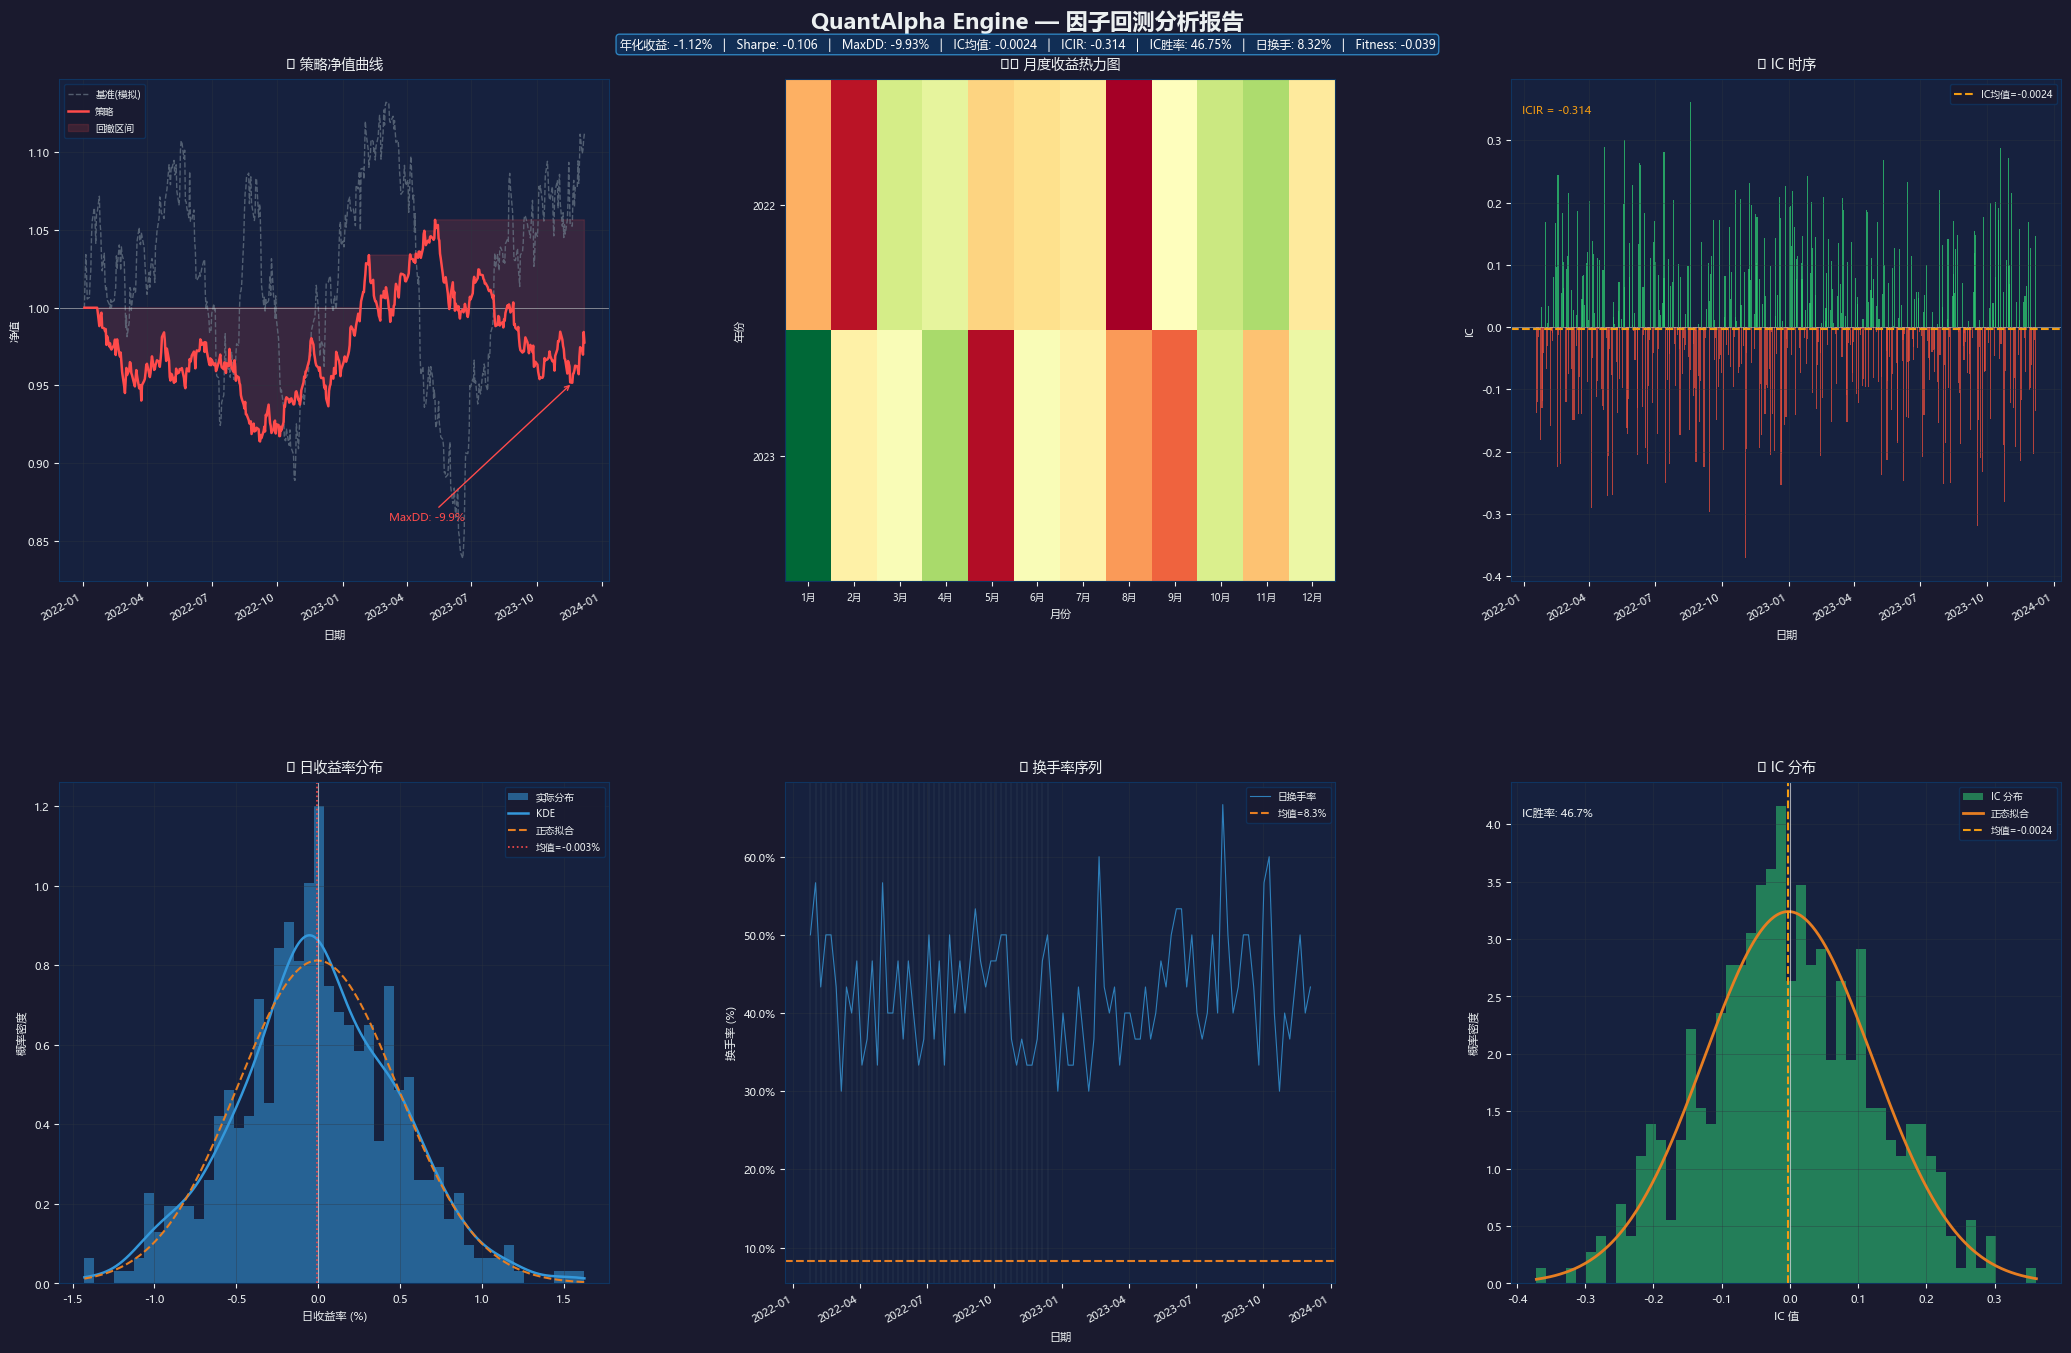

In [11]:
# ─── 回测因子 3：综合技术因子 ───
print('=' * 55)
print('  回测：综合技术因子')
print('=' * 55)

engine3 = VectorEngine(
    factor         = factor_tech,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,
    decay          = DECAY,
    industry       = INDUSTRY,
)
result3 = engine3.run()
result3.print_summary()
result3.plot()

In [12]:
# 汇总对比表
comparison = pd.DataFrame({
    '反转动量':  result1.metrics,
    '量价背离':  result2.metrics,
    '技术动量':  result3.metrics,
}).T

# 选择核心指标展示
key_cols = ['年化收益率', '年化波动率', 'Sharpe_Ratio', '最大回撤',
            'IC_Mean', 'ICIR', 'IC_胜率', '日均换手率', 'Fitness']
display_df = comparison[key_cols].copy()

# 格式化显示
pct_cols = ['年化收益率', '年化波动率', '最大回撤', 'IC_胜率', '日均换手率']
for col in pct_cols:
    display_df[col] = display_df[col].apply(lambda v: f'{v*100:.2f}%' if pd.notna(v) else 'N/A')
for col in ['Sharpe_Ratio', 'IC_Mean', 'ICIR', 'Fitness']:
    display_df[col] = display_df[col].apply(lambda v: f'{v:.4f}' if pd.notna(v) else 'N/A')

print('\n=== 三因子绩效对比 ===')
print(display_df.to_string())


=== 三因子绩效对比 ===
       年化收益率  年化波动率 Sharpe_Ratio     最大回撤  IC_Mean     ICIR   IC_胜率   日均换手率  Fitness
反转动量   0.50%  8.00%       0.1025  -10.44%   0.0100   1.3123  54.22%  12.85%   0.0202
量价背离   1.68%  7.16%       0.2679   -9.12%   0.0095   1.7369  54.86%  11.67%   0.1015
技术动量  -1.12%  7.80%      -0.1058   -9.93%  -0.0024  -0.3143  46.75%   8.32%  -0.0389


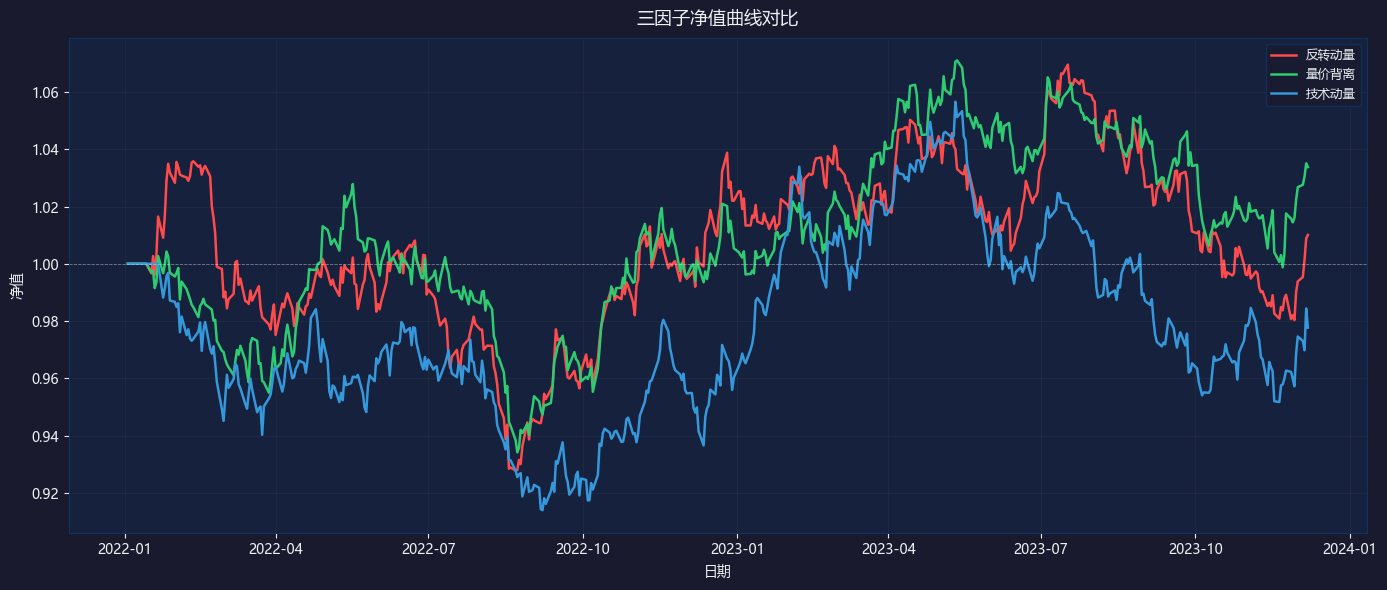

In [13]:
# 净值曲线对比图
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#1A1A2E')
ax.set_facecolor('#16213E')
ax.spines['bottom'].set_color('#0F3460')
ax.spines['left'].set_color('#0F3460')
ax.spines['top'].set_color('#0F3460')
ax.spines['right'].set_color('#0F3460')
ax.tick_params(colors='#ECF0F1')

navs = {
    '反转动量': (result1.nav, '#FF4B4B'),
    '量价背离': (result2.nav, '#2ECC71'),
    '技术动量': (result3.nav, '#3498DB'),
}

for label, (nav, color) in navs.items():
    ax.plot(nav.index, nav.values, label=label, color=color, linewidth=1.8)

ax.axhline(1.0, color='white', linewidth=0.6, alpha=0.4, linestyle='--')
ax.set_title('三因子净值曲线对比', color='#ECF0F1', fontsize=13, pad=10)
ax.set_xlabel('日期', color='#ECF0F1', fontsize=10)
ax.set_ylabel('净值', color='#ECF0F1', fontsize=10)
ax.legend(fontsize=9, facecolor='#1A1A2E', edgecolor='#0F3460',
          labelcolor='#ECF0F1')
ax.grid(True, color='#2F3640', alpha=0.5, linewidth=0.5)
plt.tight_layout()
plt.show()

## 7. 高级用法：多因子合成 + 因子加权

将多个因子线性加权合成复合 Alpha，并使用**因子值比例分配权重**（非等权）：

In [ ]:
# 多因子等权合成
alpha_combo = (
    0.4 * op.Rank(factor_reversal) +
    0.4 * op.Rank(factor_volprice) +
    0.2 * op.Rank(factor_tech)
)

print('=' * 55)
print('  回测：多因子合成 Alpha（因子值加权持仓）')
print('=' * 55)
print('  因子: 0.4×Rank(反转) + 0.4×Rank(量价) + 0.2×Rank(技术)')
print('  （本策略使用更低调仓频率 + 更集中持仓 + 因子值加权）')

engine_combo = VectorEngine(
    factor         = alpha_combo,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = 10,                  # 每2周调仓（独立于公共配置）
    top_n          = 30,                  # 精选 30 只（约占总宇宙 12%）
    weight_method  = 'factor_weighted',   # 因子值加权（非等权）
    cost_rate      = COST_RATE,           # 复用公共成本配置
    delay          = DELAY,               # 复用公共预处理配置
    decay          = DECAY,
    industry       = INDUSTRY,
)
result_combo = engine_combo.run()
result_combo.print_summary()
result_combo.plot()

## 9. 单独调用绩效指标

`Performance` 模块可以独立使用，对任意收益序列计算指标：

In [ ]:
# ─── 当前 Notebook 已使用真实数据 ───
# 数据来自：rawdata/repository（DataRepository 本地仓库）
# 数据加载流程（见 Cell 2）：
#   1. RepositoryDataLoader.load() → 加载全部 OHLCV
#   2. 过滤 close NaN = 0 的股票
#   3. 过滤有申万一级行业信息的股票
#   4. 取交集 → 最终宇宙 ~257 只股票

# ── Performance 模块独立使用示例 ────────────────────────────
# Performance 为纯静态方法类，可独立对任意收益/净值序列计算指标

nav     = result1.nav            # 净值序列 (pd.Series)
returns = result1.daily_returns  # 日收益率序列 (pd.Series)

ann_ret = Performance.calc_annualized_return(nav)
ann_vol = Performance.calc_annualized_volatility(returns)
sharpe  = Performance.calc_sharpe_ratio(returns)
mdd     = Performance.calc_max_drawdown(nav)

print('【Performance 模块独立调用示例（反转动量因子）】')
print(f'  年化收益率 : {ann_ret*100:+.2f}%')
print(f'  年化波动率 : {ann_vol*100:.2f}%')
print(f'  夏普比率   : {sharpe:.4f}')
print(f'  最大回撤   : {mdd*100:.2f}%')

print('\n💡 Performance 支持独立使用，传入净值/日收益 Series 即可计算单项指标：')
print('   Performance.calc_annualized_return(nav)        ← 年化收益率')
print('   Performance.calc_annualized_volatility(returns) ← 年化波动率')
print('   Performance.calc_sharpe_ratio(returns)          ← 夏普比率')
print('   Performance.calc_max_drawdown(nav)              ← 最大回撤')

---

## 算子速查表

```python
from quant_alpha_engine.ops import AlphaOps as op

# 时序类
op.Ts_Sum(df, window)        # 滑动求和
op.Ts_Mean(df, window)       # 滑动均值（移动平均）
op.Ts_Max(df, window)        # 滑动最大值
op.Ts_Min(df, window)        # 滑动最小值
op.Ts_Std(df, window)        # 滑动标准差
op.Ts_Delta(df, period)      # df - df.shift(period)
op.Ts_Delay(df, period)      # df.shift(period) 数据滞后
op.Ts_Rank(df, window)       # 窗口内时序百分比排名 [0,1]
op.Ts_Corr(df1, df2, window) # 滚动相关系数 [-1,1]

# 截面类（每日横截面操作）
op.Rank(df)                  # 截面百分比排名 [0,1]
op.ZScore(df)                # 截面 Z-Score 标准化
op.Scale(df, a=1)            # 截面绝对值之和缩放至 a

# 特殊类
op.Decay_Linear(df, d)       # 线性加权衰减移动平均（WQ核心算子）
op.Neutralize(df, industry)  # 行业中性化（OLS残差法）
```